# [3-1] Dropout

In [1]:
# 1. Module import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 2.딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)

Using PyTorch version: 1.9.0+cpu Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
# 3. MNIST 데이터 다운로드 (train, test set 분리하기)
train_dataset = datasets.MNIST(root = ".\data\MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = ".\data\MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

C:\ProgramData\Anaconda3\envs\py37_torch19\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# 4. 데이터 확인하기 (1)
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


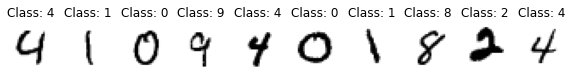

In [6]:
# 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [12]:
# 6. MLP 모델 설계하기
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [13]:
# 7. optimaziser, objective function 설정하기
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
# 8.MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [14]:
# 10. MLP 학습을 실행하면서 train, test set의 loss 및 test set accuracy를 확인하기
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.310492
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.351435
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.313641
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.339249
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.351360
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.311779
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.336711
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.361833
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.282823
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.257225

[EPOCH: 1], 	Test Loss: 2.2810, 	Test Accuracy: 13.22 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.319211
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.238786
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.348453
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.250652
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 2.245494
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 2.276132
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 2.238644
T

# [3-2] Dropout + ReLU

In [15]:
# 6. MLP 모델 설계하기
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [16]:
# 7. optimaziser, objective function 설정하기
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [17]:
# 10. MLP 학습을 실행하면서 train, test set의 loss 및 test set accuracy를 확인하기
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.302333
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.025934
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 1.254321
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.747134
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.764605
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.396510
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.443004
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.454116
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.505506
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.415288

[EPOCH: 1], 	Test Loss: 0.3234, 	Test Accuracy: 90.73 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.417233
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.231884
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.242779
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.276099
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.214657
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.150647
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.433636
T

# [3-3] Dropout + ReLU + Batch Normalization

In [18]:
# 6. MLP 모델 설계하기
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # 첫 번째 Fully connected Layer
        self.fc2 = nn.Linear(512, 256)  # 두 번째 FCL
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)  # 첫번째 Fully Connected Layer output이 512라서 512차원으로 설정
        self.batch_norm2 = nn.BatchNorm1d(256)  # 두 번째 FCL output 256

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x) # 활성함수 전/후 적용은 사람마다 선호가 다름
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [19]:
# 7. optimaziser, objective function 설정하기
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
# 10. MLP 학습을 실행하면서 train, test set의 loss 및 test set accuracy를 확인하기
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.309891
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.980181
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.339557
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.380613
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.403145
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.589274
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.213979
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.409122
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.200580
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.118328

[EPOCH: 1], 	Test Loss: 0.1534, 	Test Accuracy: 95.53 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.179774
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.445535
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.293199
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.234365
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.116958
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.280928
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.185458
T

# [3-4] Dropout + ReLU + Batch Normalization + He Uniform Initialization

In [21]:
# 7. optimaziser, objective function 설정하기
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)  # kaiming_uniform_ = He uniform
        
model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [22]:
# 10. MLP 학습을 실행하면서 train, test set의 loss 및 test set accuracy를 확인하기
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.831714
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 1.091002
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.863131
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.484267
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.659882
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.217742
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.773948
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.479247
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.261987
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.367479

[EPOCH: 1], 	Test Loss: 0.2265, 	Test Accuracy: 93.19 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.438582
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.430251
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.218265
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.646664
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.429092
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.438389
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.155278
T

# [3-5] Dropout + ReLU + Batch Normalization + He Uniform Initialization + Adam

In [23]:
# 7. optimaziser, objective function 설정하기
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)  # kaiming_uniform_ = He uniform
        
model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
# 10. MLP 학습을 실행하면서 train, test set의 loss 및 test set accuracy를 확인하기
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.886991
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.480096
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.090774
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.623801
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.057374
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.368854
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.353129
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.210657
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.206812
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.382598

[EPOCH: 1], 	Test Loss: 0.1363, 	Test Accuracy: 95.65 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.106601
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.124082
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.330148
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.570008
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.325265
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.265385
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.131839
T

# [3-6] AutoEncoder

In [25]:
# 3. FashionMNIST 데이터 다운로드(train, test set 분리)
train_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100.0%


Extracting ./data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



100.6%


Extracting ./data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



100.0%


Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



119.3%

Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



In [26]:
# 4. 데이터 확인하기 (1)
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


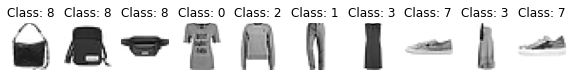

In [27]:
# 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [28]:
# 6. AutoEncoder (AE) 모델 설계하기
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [29]:
# 7. optimizer, objective function 설정하기
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [30]:
# 8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, opimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28*28).to(DEVICE)
        target = image.view(-1, 28*28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [31]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)

    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.209709
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.026261
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.026838
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.022253
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.017892
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.017940
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.017437
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.016153
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.016447
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.014964

[EPOCH: 1], 	Test Loss: 0.0155


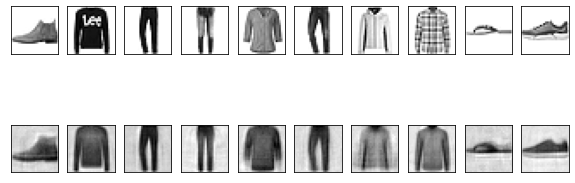

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.017510
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.016150
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.015717
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.013910
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.014628
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.013437
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.015707
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.018625
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.013593
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.010576

[EPOCH: 2], 	Test Loss: 0.0131


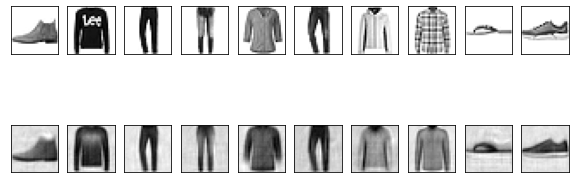

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.013413
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.010255
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.011658
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.016111
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.013131
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.010773
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.012169
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.011980
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.013125
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.014415

[EPOCH: 3], 	Test Loss: 0.0120


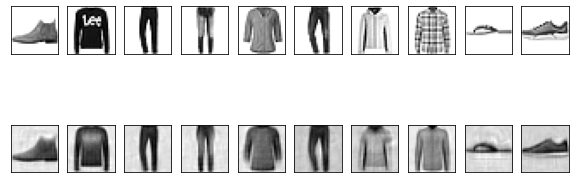

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.011504
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.014260
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.012538
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.010061
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.011395
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.013044
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.010781
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.010938
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.011877
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.012845

[EPOCH: 4], 	Test Loss: 0.0113


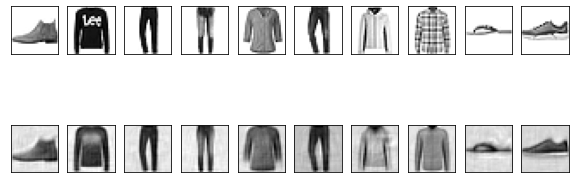

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.011667
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.013231
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.011808
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.009256
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.010754
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.011924
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.011152
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.011067
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.010380
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.012444

[EPOCH: 5], 	Test Loss: 0.0109


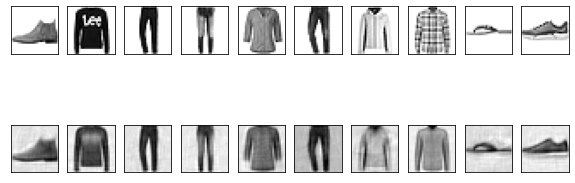

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.011316
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.010772
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.010694
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.011688
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.012359
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.012136
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.009591
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.010209
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.011168
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.010287

[EPOCH: 6], 	Test Loss: 0.0105


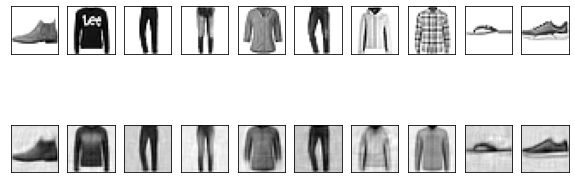

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.011400
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.009173
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.008184
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.008249
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.010131
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.009740
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.007975
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.011291
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.010651
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.012611

[EPOCH: 7], 	Test Loss: 0.0108


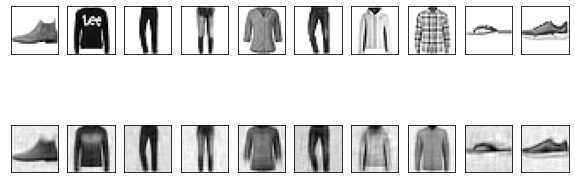

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.008976
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.008096
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.013310
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.008695
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.009795
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.010163
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.010838
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.009964
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.012253
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.007206

[EPOCH: 8], 	Test Loss: 0.0102


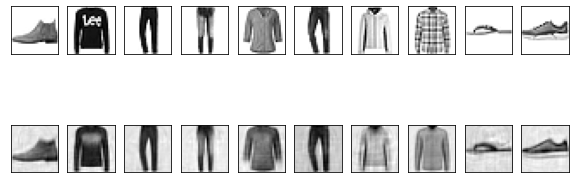

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.008871
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.010578
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.012176
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.009339
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.010729
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.008889
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.009917
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.012114
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.012410
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.010003

[EPOCH: 9], 	Test Loss: 0.0100


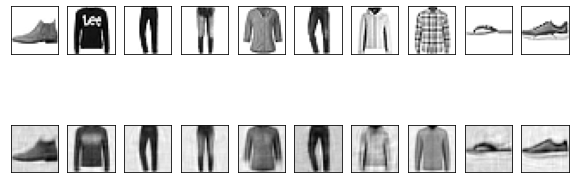

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.011106
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.007111
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.009912
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.009507
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.009960
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.011286
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.011743
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.009743
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.008988
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.009742

[EPOCH: 10], 	Test Loss: 0.0099


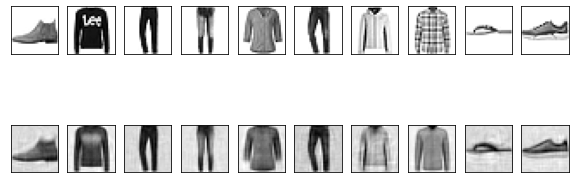

In [32]:
# 10. AutoEncoder 학습 실행하며 test set의 Reconstruction Error 확인하기
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()